# Part A - Segmentation

## In Fiji (manually)

1. All movies in the dataset are split channels into Ch1 (non-fluorescence one) and Ch2 (fluorescence one)
2. For each channel, movies are saved as image sequences in the corresponding folder (the 'all_cells' folder for the non-fluorescence channel and the 'fluor' folder for the fluorescence one).

## Python
1. Names of all image sequence files in the channel folder are stored in 'files_name', and the path from the current directory is added to generate 'files' for later segmentation.
2. 'files' is sorted by name to order the image sequences according to the movie frame sequence.
3. Using Omnipose for cell segementation
    'bact_phase_omni' model for all cells (image files in 'all_cells' folder)
    'bact_fluor_omni' model for fluorescence cells (image files in "fluor' folder)
4. Save output files in masks and outlines folders

**Jupyter notebook code was transferred to the python file 'py_image_seg.py' for running**

Each step was commented below:

**Automatically reload changes modules**  
IPython Magic commands. Used in a Jupyter Notebook or IPython environment to dynamically reload modules without having to manually restart the Jupyter Notebook kernel or re-import the modules.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import all needed packages**

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

**Generate object 'file', including all image sequences from the same movie**  
file_path is changed manually for different movies

In [10]:
# test
os.getcwd()

'/Users/herbert/Downloads'

In [11]:
file_path = '/Users/herbert/Downloads/cell_seg_test/'
files_name = [f for f in os.listdir(file_path) if f.endswith('.tif')] # Read all file names in the folder ends with '.tif' and store in 'files_name'
files = [file_path + f for f in files_name]
files = sorted(files) # order by names

In [12]:
# test
print (files)

['/Users/herbert/Downloads/cell_seg_test/Native_cells0000.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0001.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0002.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0003.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0004.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0005.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0006.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0007.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0008.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0009.tif', '/Users/herbert/Downloads/cell_seg_test/Native_cells0010.tif']


**Visualize each image before segmentation**  
Code adapted from Omnipose website https://omnipose.readthedocs.io/examples/mono_channel_bact.html (accessed on Oct.2024)

Original image shape: (92, 63)
data type: uint8
data range: min 71, max 177

Original image shape: (256, 128)
data type: uint8
data range: min 78, max 183

Original image shape: (256, 128)
data type: uint8
data range: min 85, max 179

Original image shape: (256, 128)
data type: uint8
data range: min 61, max 190

Original image shape: (256, 128)
data type: uint8
data range: min 83, max 180

Original image shape: (256, 128)
data type: uint8
data range: min 87, max 181

Original image shape: (256, 128)
data type: uint8
data range: min 83, max 184

Original image shape: (256, 128)
data type: uint8
data range: min 86, max 184

Original image shape: (256, 128)
data type: uint8
data range: min 81, max 180

Original image shape: (256, 128)
data type: uint8
data range: min 80, max 186

Original image shape: (256, 128)
data type: uint8
data range: min 87, max 178


number of images: 11


new shape:  (92, 9)
new shape:  (256, 74)
new shape:  (256, 74)
new shape:  (256, 74)
new shape:  (256, 74)
n

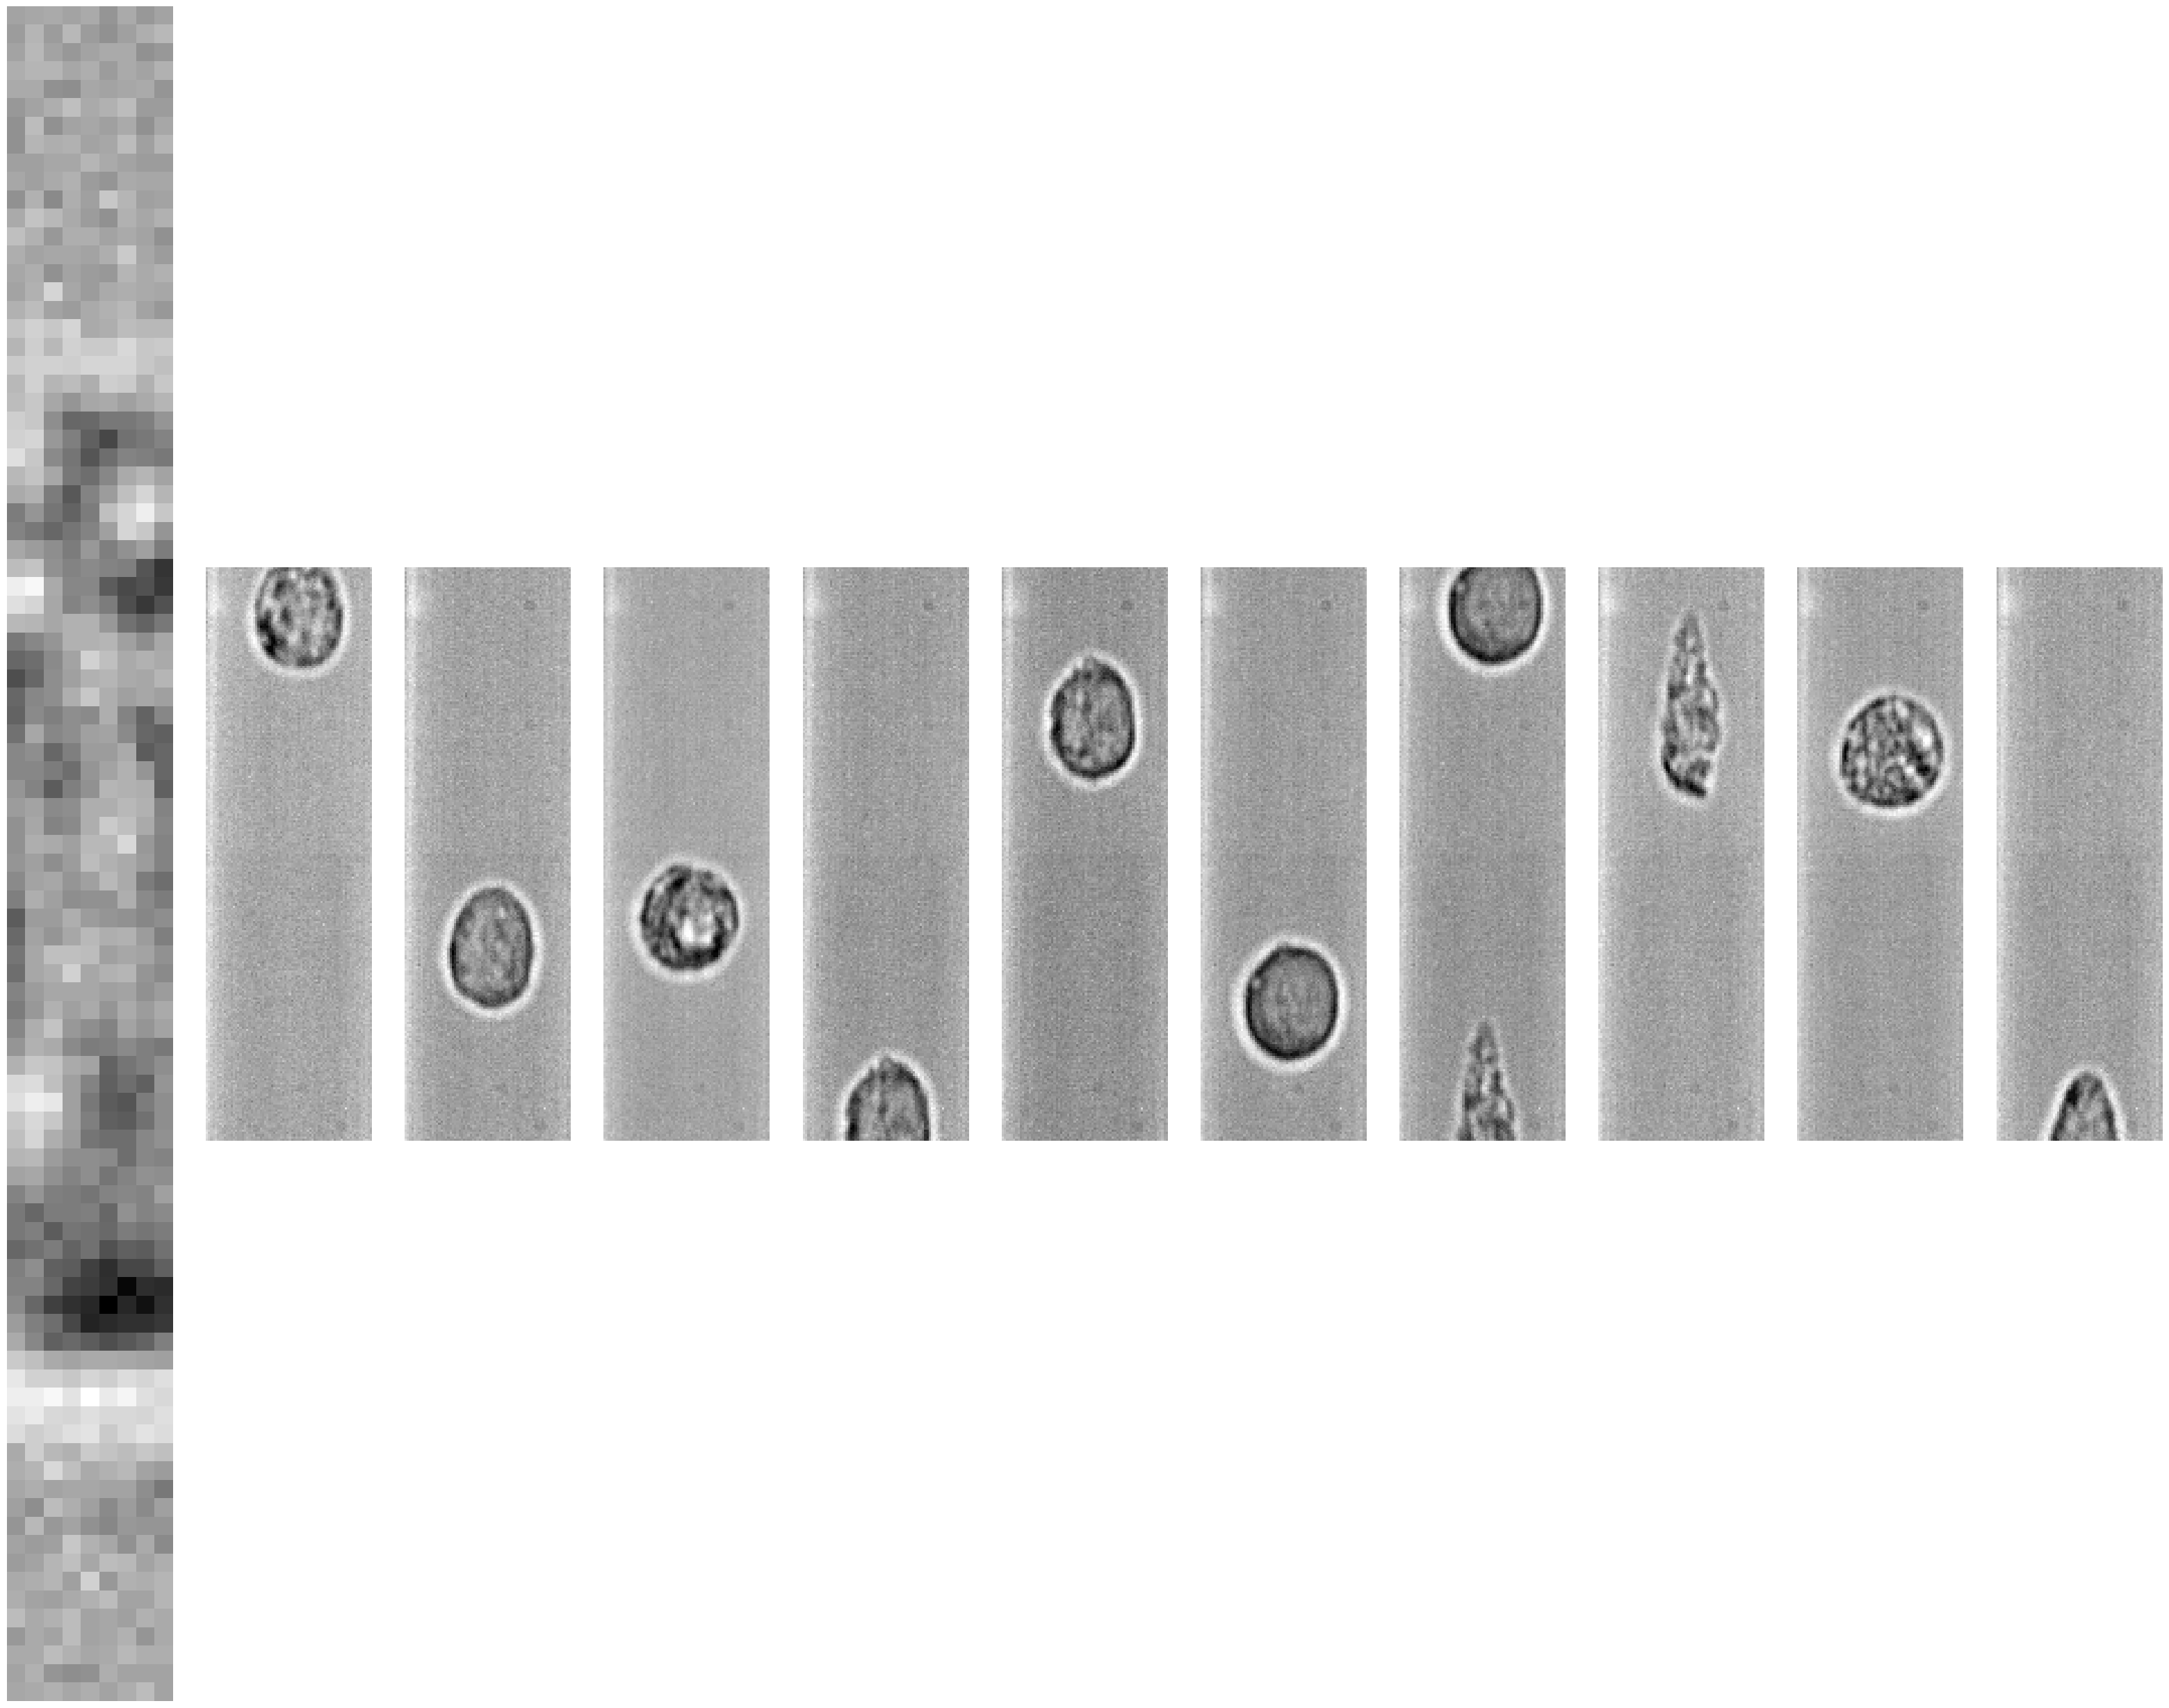

In [31]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99

#load images
imgs = [io.imread(f) for f in files]

# Add a function to crop the image to the desired field of view
def crop_width(image, left_margin=25, right_margin=25): #Which is confirmed by visual inspection of randomly selected 10 images
    """
    Crop the width of the image to exclude undesired borders (e.g., tubes).
    
    Parameters:
    - image: Input 2D numpy array (grayscale image).
    - left_margin: Number of pixels to remove from the left border.
    - right_margin: Number of pixels to remove from the right border.
    
    Returns:
    - Cropped image.
    """
    height, width = image.shape
    return image[:, left_margin:width - right_margin]  # Crop only the width

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range: min {}, max {}\n'.format(i.min(),i.max()))
nimg = len(imgs)
print('\nnumber of images:',nimg)

fig = plt.figure(figsize=[40]*2,frameon=False) # initialize figure
print('\n')
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale
        
    imgs[k] = normalize99(imgs[k])

    # Apply the width crop
    left_margin = 27  # Adjust as needed to remove the tube on the left
    right_margin = 27  # Adjust as needed to remove the tube on the right
    imgs[k] = crop_width(imgs[k], left_margin=left_margin, right_margin=right_margin)
    
    # imgs[k] = np.pad(imgs[k],10,'edge')
    print('new shape: ', imgs[k].shape)
    plt.subplot(1,len(files),k+1)
    plt.imshow(imgs[k],cmap='gray')
    plt.axis('off')

**Segmentation with Omnipose**  
Omnipose uses grayscale or color images to generate segmentation masks through a neural network model and it has been optimized for bacteria, which makes it a good segmentation package.

In [6]:
import cellpose_omni
from cellpose_omni import models

**Model selection**

In [7]:
from cellpose_omni.models import MODEL_NAMES
MODEL_NAMES

['bact_phase_omni',
 'bact_fluor_omni',
 'worm_omni',
 'worm_bact_omni',
 'worm_high_res_omni',
 'cyto2_omni',
 'plant_omni',
 'bact_phase_cp',
 'bact_fluor_cp',
 'plant_cp',
 'worm_cp',
 'cyto',
 'nuclei',
 'cyto2']

In [38]:
# model_name = 'nuclei' # for cancer cells
model_name = 'cyto' # for cancer cells
model = models.CellposeModel(model_type=model_name)

2024-11-25 19:15:09,325 [INFO] >>cyto<< model set to be used
2024-11-25 19:15:09,327 [INFO] >>>> using CPU


1. Using time package to monitor the progress of segmentation
2. define parameters for the model

In [45]:
import time
chans = [0,0] #this means segment based on first channel, no second channel 

n = [0] # make a list of integers to select which images you want to segment
# n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':chans, # always define this with the model
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          #'anisotrop': 1.5, # Adjust boundary smoothness
          'mask_threshold': 0.3, # erode or dilate masks with higher or lower values between -5 and 5 
          'flow_threshold': 0.4, # default is .4, but only needed if there are spurious masks to clean up; slows down output
          # "remove_edge_points": True, # Remove spurious boundaries
          # "stitch_thresh": 0.1, # Optimize boundary merging
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': False, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': None, # default None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average network outputs, usually not needed 
          'affinity_seg': False, # new feature, stay tuned...
         }

tic = time.time() 
# masks, flows, styles = model.eval(imgs, diameter=40, **params)
masks, flows, styles = model.eval(imgs, **params)
net_time = time.time() - tic

print('total segmentation time: {}s'.format(net_time))

  0%|          | 0/11 [00:00<?, ?it/s]

total segmentation time: 7.176781177520752s


**Save output files**  
Create two folders (masks and outlines) in the same directory as image files

In [46]:
io.save_masks(imgs, masks, flows, files, 
              png=False,
              tif=True, # whether to use PNG or TIF format
              suffix='', # suffix to add to files if needed 
              save_flows=False, # saves both RGB depiction as *_flows.png and the raw components as *_dP.tif
              save_outlines=True, # save outline images 
              dir_above=0, # save in the file directory
              # dir_above=1, # save output in the file directory or in the directory above (at the level of the file directory)
              in_folders=True, # save output in folders (recommended)
              save_txt=False, # txt file for outlines in imageJ
              save_ncolor=False) # save ncolor version of masks for visualization and editing 

**Plot the first mask file for checking**

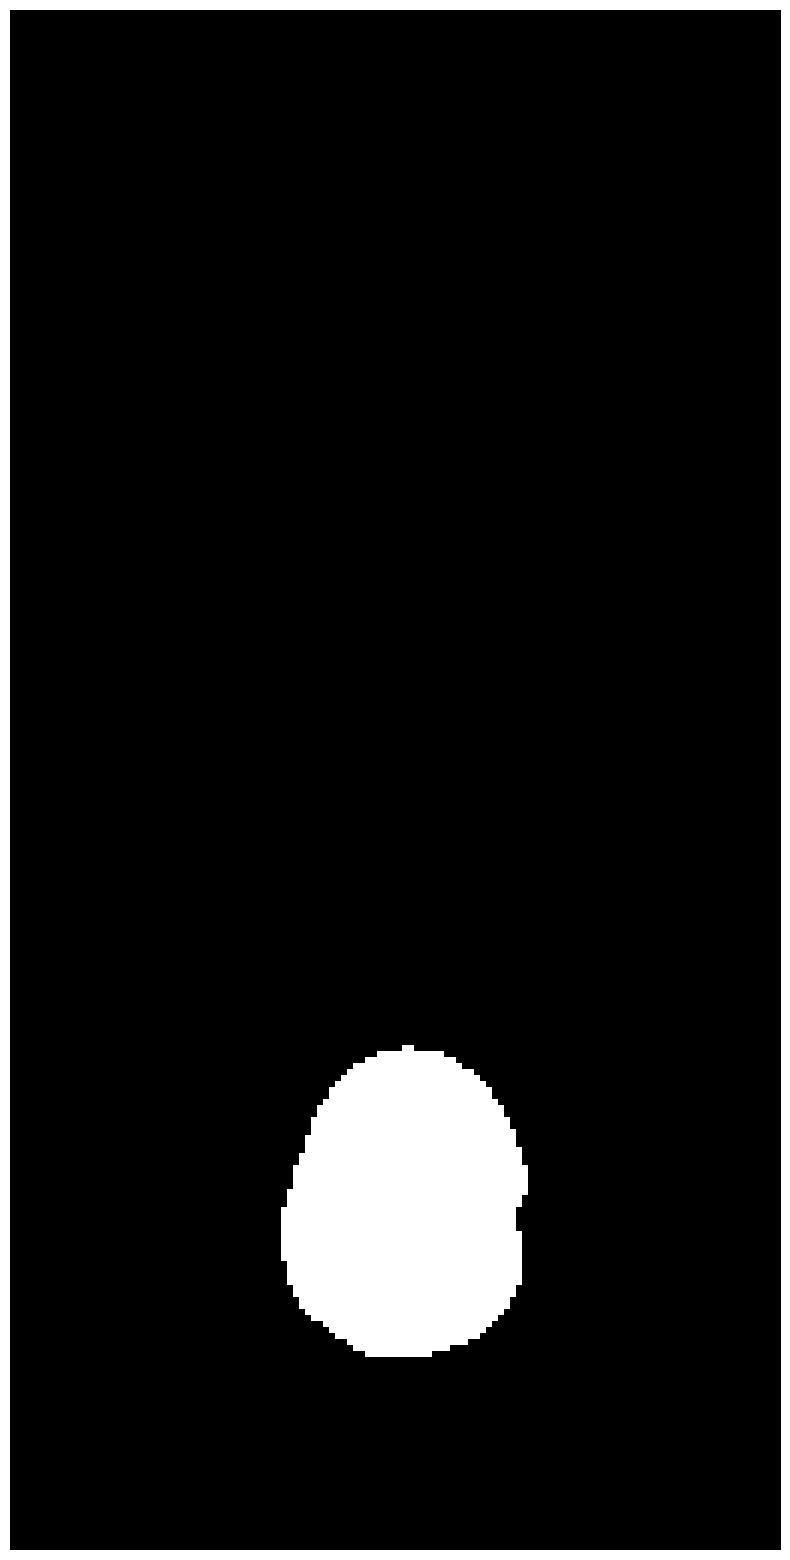

In [39]:
maski = masks[0] # get masks
bdi = flows[0][-1] # get boundaries

fig = plt.figure(figsize=[20]*2,frameon=False) 
imgs[0] = normalize99(imgs[0])
plt.imshow(maski,cmap='gray')

plt.axis('off')

plt.show()